# 导入包

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import warnings 
warnings.filterwarnings("ignore")

# 导入数据

In [ ]:
nrows = None

df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/sensor_train.csv',sep=',',nrows=nrows)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/sensor_test.csv',sep=',',nrows=nrows)
df_submit = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/提交结果示例.csv',sep=',',nrows=nrows)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 合并数据

In [ ]:
df_train['flag'] = 'train'
df_test['flag'] = 'test'
df_test['behavior_id'] = -1
df_train_test = pd.concat([df_train, df_test])

In [ ]:
df_train_test = df_train_test.sort_values(['flag','fragment_id','time_point'])

In [ ]:
df_train_test['acc_all'] = (df_train_test['acc_x'] ** 2 + df_train_test['acc_y'] ** 2 + df_train_test['acc_z'] ** 2) ** 0.5
df_train_test['acc_allg'] = (df_train_test['acc_xg'] ** 2 + df_train_test['acc_yg'] ** 2 + df_train_test['acc_zg'] ** 2) ** 0.5

# 查看字段和数据

In [ ]:
df_train_test.columns

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'flag', 'acc_all', 'acc_allg'],
      dtype='object')

In [ ]:
df_train_test.head()

fragment_id  time_point  acc_x  ...  flag   acc_all   acc_allg
0            0          71    0.2  ...  test  1.183216  10.619322
1            0         150    0.0  ...  test  1.220656  10.162677
2            0         244   -0.2  ...  test  2.537716   9.274158
3            0         326    2.3  ...  test  2.830194   6.169279
4            0         409   -0.3  ...  test  3.597221  12.886039

[5 rows x 12 columns]

# 数据聚合

In [ ]:
agg_func = lambda x: list(x)
map_agg_func = {    
    'time_point' : agg_func,
    
    'acc_all' : agg_func,
    'acc_allg' : agg_func,
    
    'acc_x' : agg_func,
    'acc_y' : agg_func,
    'acc_z' : agg_func,
    
    'acc_xg' : agg_func,
    'acc_yg' : agg_func,
    'acc_zg' : agg_func
}
df_train_test_list = df_train_test.groupby(['flag','fragment_id','behavior_id']).agg(map_agg_func).reset_index()

In [ ]:
df_train_test_list.head()

flag  ...                                             acc_zg
0  test  ...  [9.2, 8.2, 7.6, 3.4, 12.4, 9.8, 8.5, 8.7, 8.1,...
1  test  ...  [8.4, 8.4, 8.3, 8.2, 8.2, 8.4, 8.3, 8.3, 8.6, ...
2  test  ...  [9.4, 9.1, 8.8, 9.6, 9.7, 9.4, 9.2, 9.1, 9.0, ...
3  test  ...  [7.7, 7.3, 7.4, 7.5, 7.3, 7.1, 7.5, 7.6, 7.3, ...
4  test  ...  [8.6, 7.5, 6.7, 8.3, 9.1, 8.4, 5.9, 8.8, 6.4, ...

[5 rows x 12 columns]

# 抽取特征

In [ ]:
map_features_fun = {
    # 时域
    'time_sum' : lambda x:np.sum(x),
    'time_mean' : lambda x: np.mean(x),
    'time_std' : lambda x: np.std(x),
    'time_var' : lambda x: np.var(x),
    'time_max' : lambda x: np.max(x),
    'time_min' : lambda x: np.min(x),
    'time_median' : lambda x: np.median(x),
    'time_energy' : lambda x: np.sum(np.power(x,2)),
    'time_mad' : lambda x: np.mean(np.absolute(x - np.mean(x))),
    'time_percent_9' : lambda x: np.percentile(x, 0.9),
    'time_percent_75' : lambda x: np.percentile(x, 0.75),
    'time_percent_25' : lambda x: np.percentile(x, 0.25),
    'time_percent_1' : lambda x: np.percentile(x, 0.1),
    'time_percent_75_25' : lambda x: np.percentile(x,75)-np.percentile(x,25),
    'time_range' : lambda x:np.max(x)-np.min(x),
    'time_zcr': lambda x: (np.diff(np.sign(x))!= 0).sum(),
    'time_mcr' : lambda x: (np.diff(np.sign(x-np.mean(x)))!= 0).sum(),
    'time_minind' : lambda x: np.argmin(x),
    'time_maxind' : lambda x: np.argmax(x),
    'time_skew' : lambda x: skew(x),
    'time_kurtosis' : lambda x: kurtosis(x),
    'time_zero_big' : lambda x: np.sum(np.sign(x)>0),
    'time_zero_small' : lambda x: np.sum(np.sign(x)<0),
    'time_len' : lambda x: np.size(x),
    
    # 频域
    'fft_dc' : lambda x: np.abs(np.fft.fft(x))[0],
    'fft_mean' : lambda x: np.mean(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_var' : lambda x: np.var(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_std' : lambda x: np.std(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_sum' : lambda x: np.sum(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_entropy' : lambda x: -1.0 * np.sum(np.log2(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]/np.sum(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]))),
    'fft_energy' : lambda x: np.sum(np.power(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1],2)),
    'fft_skew' : lambda x: skew(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_kurtosis' : lambda x: kurtosis(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_max' : lambda x: np.max(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_min' : lambda x: np.min(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_maxind' : lambda x: np.argmax(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1]),
    'fft_minind' : lambda x: np.argmin(np.abs(np.fft.fft(x))[1:int(len(x) / 2)+1])
}

In [ ]:
df_train_test_features = df_train_test_list[['flag','fragment_id','behavior_id']]
for col in ['acc_all','acc_allg','acc_x','acc_y','acc_z','acc_xg','acc_yg','acc_zg']:
    for f_name, f_fun in tqdm(map_features_fun.items()):
        df_train_test_features[col + '_' + f_name] = df_train_test_list[col].map(f_fun)




  0%|          | 0/37 [00:00<?, ?it/s]


  3%|▎         | 1/37 [00:00<00:05,  6.80it/s]


  5%|▌         | 2/37 [00:00<00:05,  6.49it/s]


  8%|▊         | 3/37 [00:00<00:07,  4.42it/s]


 11%|█         | 4/37 [00:01<00:09,  3.64it/s]


 14%|█▎        | 5/37 [00:01<00:07,  4.26it/s]


 16%|█▌        | 6/37 [00:01<00:07,  4.16it/s]


 19%|█▉        | 7/37 [00:02<00:11,  2.60it/s]


 22%|██▏       | 8/37 [00:02<00:09,  3.11it/s]


 24%|██▍       | 9/37 [00:02<00:09,  2.98it/s]


 27%|██▋       | 10/37 [00:04<00:18,  1.47it/s]


 30%|██▉       | 11/37 [00:05<00:23,  1.09it/s]


 32%|███▏      | 12/37 [00:07<00:27,  1.09s/it]


 35%|███▌      | 13/37 [00:08<00:29,  1.22s/it]


 38%|███▊      | 14/37 [00:11<00:40,  1.76s/it]


 41%|████      | 15/37 [00:12<00:29,  1.32s/it]


 43%|████▎     | 16/37 [00:12<00:20,  1.00it/s]


 46%|████▌     | 17/37 [00:12<00:16,  1.19it/s]


 49%|████▊     | 18/37 [00:13<00:12,  1.51it/s]


 51%|█████▏    | 19/37 [00:13<00:09,  1.95it/s]


 54%|█████▍    

In [ ]:
df_train_test_features.head()

flag  fragment_id  ...  acc_zg_fft_maxind  acc_zg_fft_minind
0  test            0  ...                 23                 10
1  test            1  ...                 11                 22
2  test            2  ...                 15                 18
3  test            3  ...                 17                  3
4  test            4  ...                 17                 21

[5 rows x 299 columns]

# 模型参数

In [ ]:
params = {
          'application': 'multiclass',
          'num_class': 19,
          'boosting': 'gbdt',
          #'metric': ['multi_logloss','multi_error'],
          'num_leaves': 63,
          'learning_rate': 0.1,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.7,
          'min_split_gain': 0.01,
          'min_child_samples': 120,
          'min_child_weight': 0.01,
          'lambda_l2': 0.05,
          'verbosity': -1,
          'data_random_seed': 2020
         }  

# 获取训练和测试数据

In [ ]:
cols = [c for c in df_train_test_features.columns if c not in ['flag','fragment_id','behavior_id']]

In [ ]:
# cols = ['acc_yg_time_max','acc_xg_time_energy','acc_yg_time_energy','acc_y_time_percent_75_25','acc_yg_time_range','acc_xg_fft_dc',\
#  'acc_allg_time_mean','acc_allg_time_sum','acc_y_fft_max','acc_yg_time_percent_9','acc_xg_time_max','acc_yg_time_median','acc_zg_time_mean',\
#  'acc_yg_fft_dc','acc_yg_time_sum','acc_allg_time_median','acc_zg_time_sum','acc_xg_time_percent_9','acc_yg_time_percent_75','acc_yg_time_mean',\
#  'acc_allg_time_energy','acc_yg_time_std','acc_all_time_median','acc_xg_time_percent_75_25','acc_xg_time_mean','acc_zg_time_energy',\
#  'acc_allg_time_percent_75_25','acc_x_time_percent_75_25','acc_all_time_sum','acc_y_fft_var','acc_x_time_zcr','acc_y_fft_maxind',\
#  'acc_xg_time_sum','acc_zg_time_median','acc_y_time_sum','acc_y_time_zcr','acc_zg_time_percent_9','acc_xg_time_zero_big',\
#  'acc_xg_time_median','acc_yg_time_zero_big','acc_zg_time_mcr','acc_yg_time_min','acc_y_fft_skew','acc_x_fft_max','acc_xg_time_zero_small',\
#  'acc_x_time_sum','acc_yg_time_percent_1','acc_zg_time_percent_1','acc_x_time_mad','acc_allg_fft_maxind','acc_yg_time_zcr','acc_all_time_percent_9','acc_zg_fft_dc']

In [ ]:
X = df_train_test_features[df_train_test_features['flag']=='train'][cols].values
y = df_train_test_features[df_train_test_features['flag']=='train']['behavior_id'].values
X_test = df_train_test_features[df_train_test_features['flag']=='test'][cols].values

In [ ]:
seed = 2020
folds = 5
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

In [ ]:
df_train_stacking = pd.DataFrame(np.zeros((X.shape[0],19)))
df_test_stacking = pd.DataFrame(np.zeros((X_test.shape[0],19)))

# 训练模型




0it [00:00, ?it/s]

--------------- begin ---------------
Training until validation scores don't improve for 80 rounds.
[30]	training's multi_logloss: 0.76449	valid_1's multi_logloss: 1.16072
[60]	training's multi_logloss: 0.327865	valid_1's multi_logloss: 0.921348
[90]	training's multi_logloss: 0.144177	valid_1's multi_logloss: 0.849265
[120]	training's multi_logloss: 0.0610823	valid_1's multi_logloss: 0.821326
[150]	training's multi_logloss: 0.0257233	valid_1's multi_logloss: 0.815133
[180]	training's multi_logloss: 0.0114357	valid_1's multi_logloss: 0.822846
[210]	training's multi_logloss: 0.00621118	valid_1's multi_logloss: 0.829015
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.0249966	valid_1's multi_logloss: 0.814872


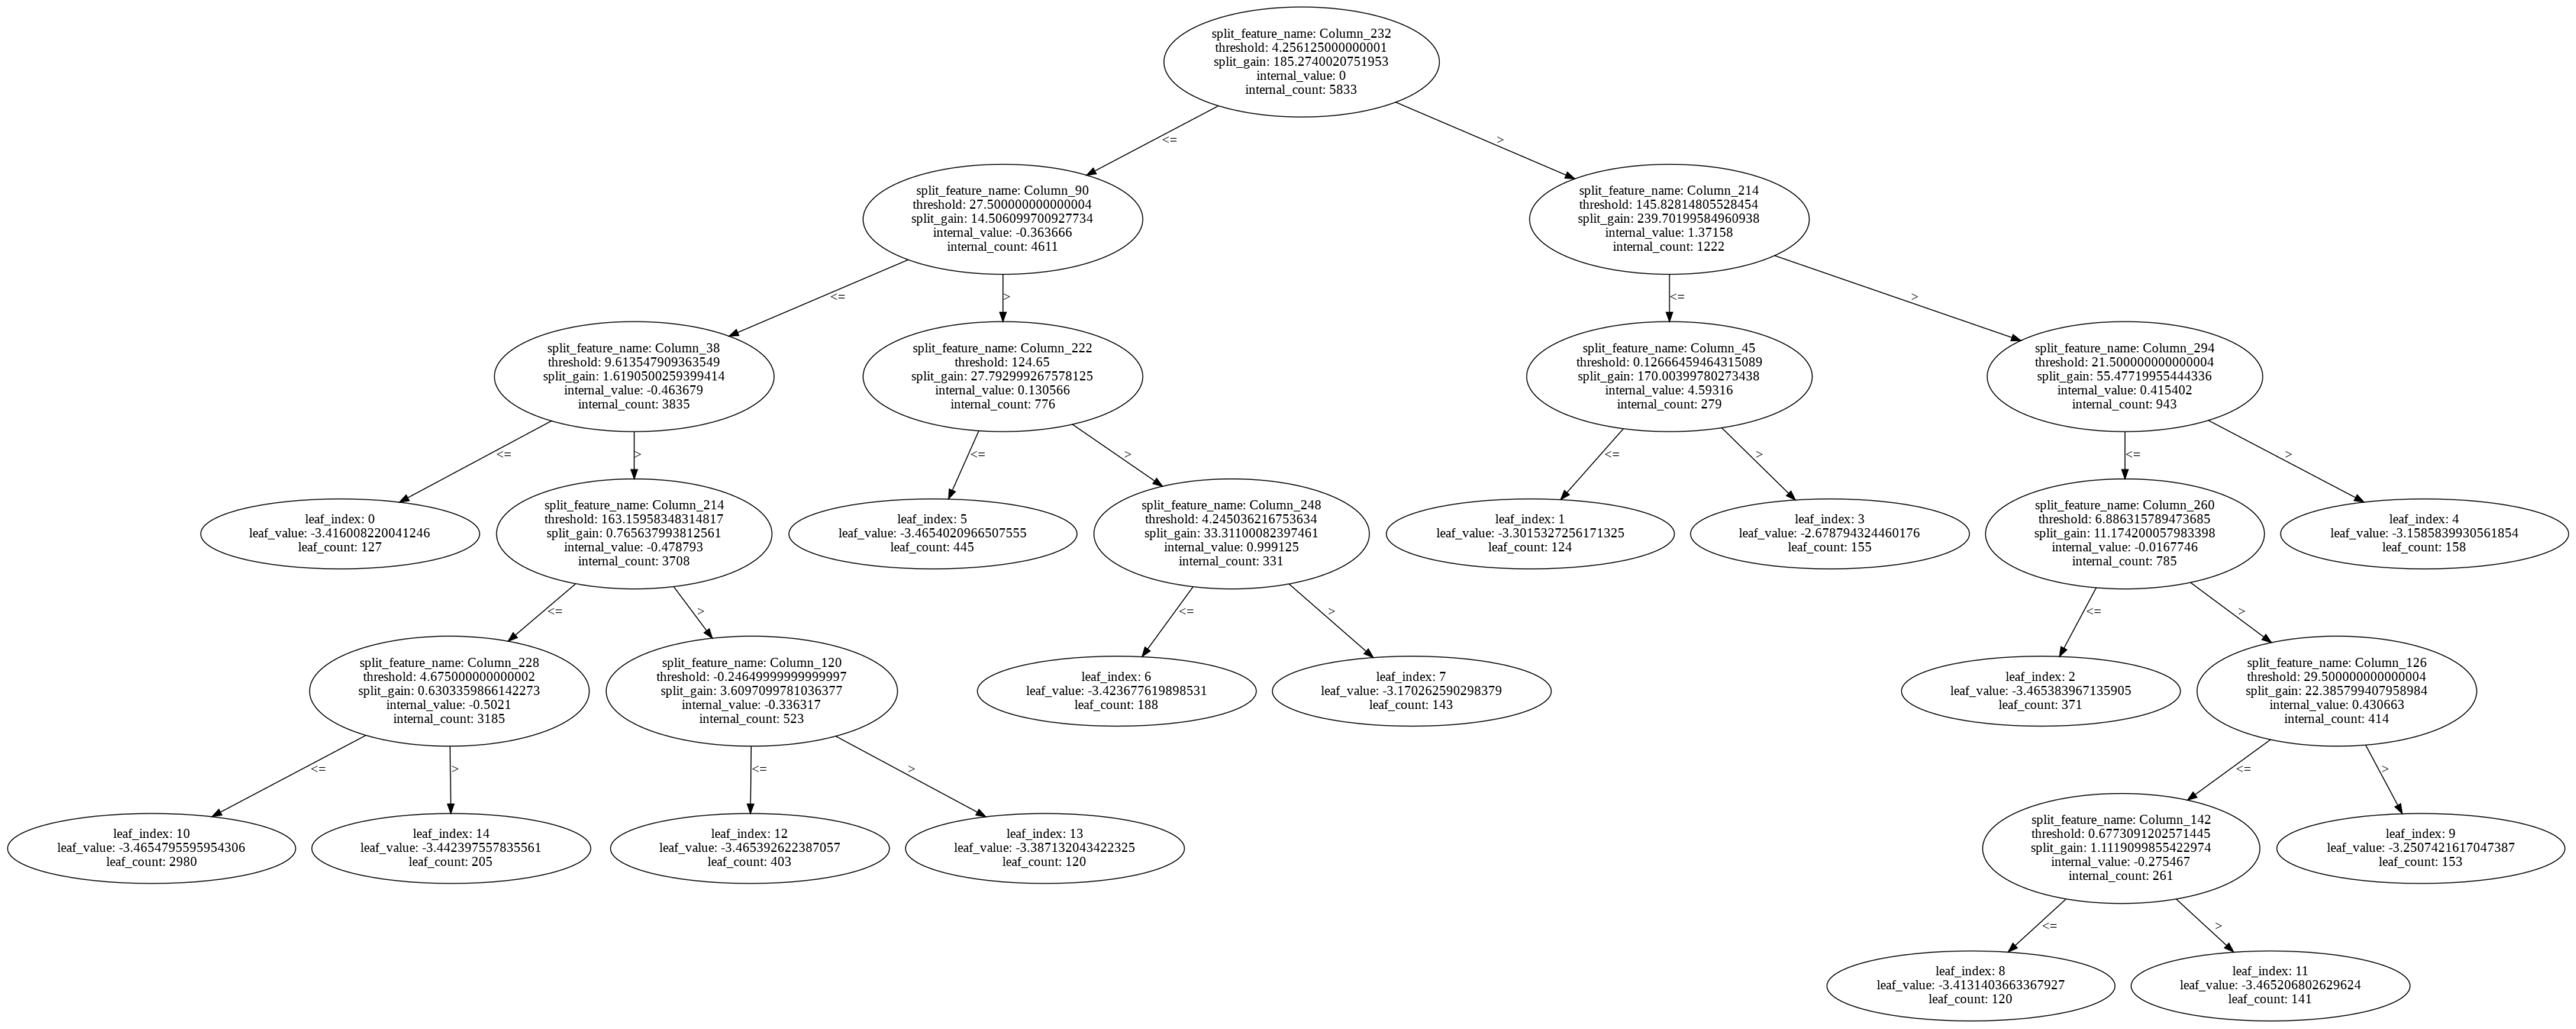

--------------- after plot begin ---------------





1it [01:10, 70.37s/it]

--------------- begin ---------------
Training until validation scores don't improve for 80 rounds.
[30]	training's multi_logloss: 0.762156	valid_1's multi_logloss: 1.18307
[60]	training's multi_logloss: 0.324666	valid_1's multi_logloss: 0.942303
[90]	training's multi_logloss: 0.140326	valid_1's multi_logloss: 0.866033
[120]	training's multi_logloss: 0.0590057	valid_1's multi_logloss: 0.841559
[150]	training's multi_logloss: 0.0249104	valid_1's multi_logloss: 0.839964
[180]	training's multi_logloss: 0.0111506	valid_1's multi_logloss: 0.852705
[210]	training's multi_logloss: 0.00612778	valid_1's multi_logloss: 0.86459
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.0359224	valid_1's multi_logloss: 0.835623


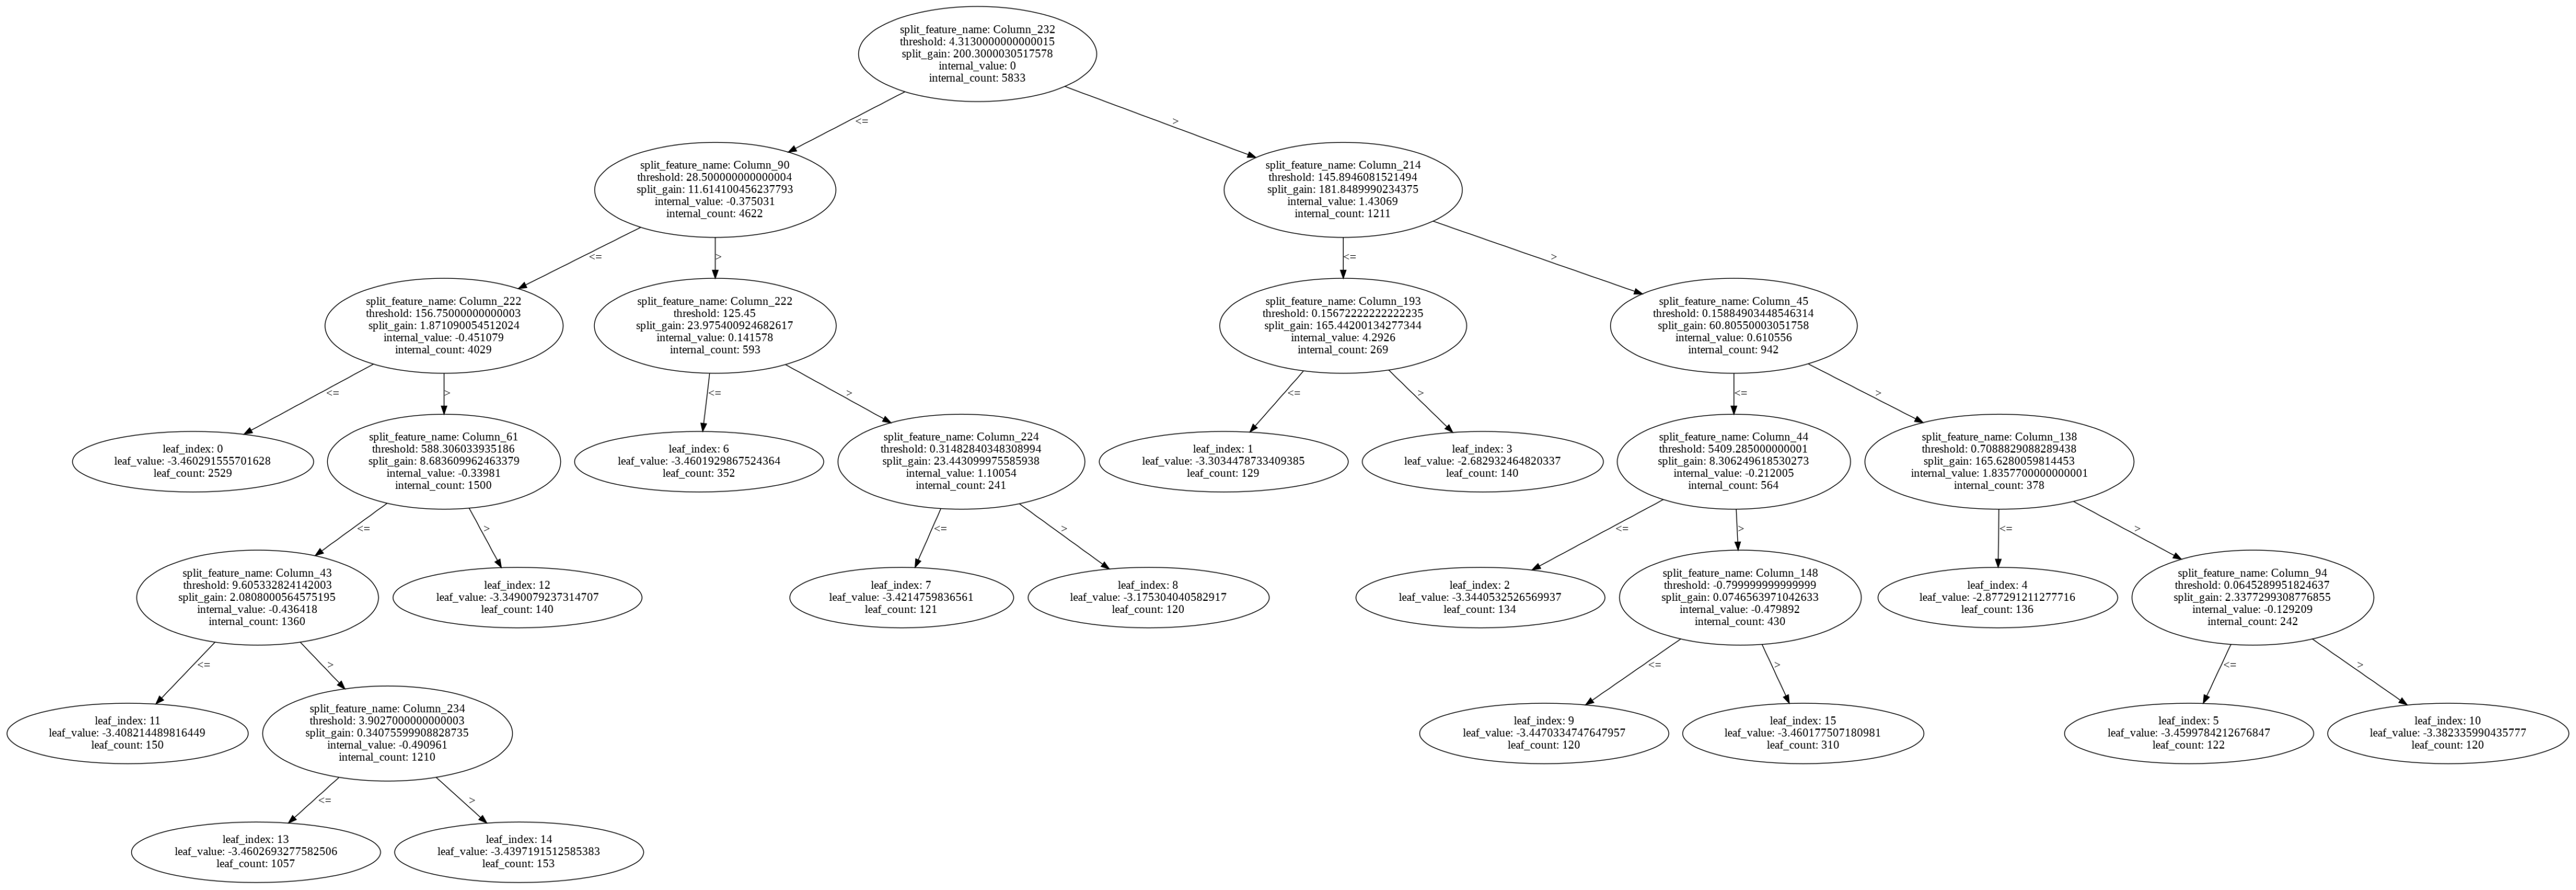

--------------- after plot begin ---------------





2it [02:18, 69.69s/it]

--------------- begin ---------------
Training until validation scores don't improve for 80 rounds.
[30]	training's multi_logloss: 0.76879	valid_1's multi_logloss: 1.1472
[60]	training's multi_logloss: 0.331972	valid_1's multi_logloss: 0.912889
[90]	training's multi_logloss: 0.143759	valid_1's multi_logloss: 0.839094
[120]	training's multi_logloss: 0.0607913	valid_1's multi_logloss: 0.813783
[150]	training's multi_logloss: 0.0257984	valid_1's multi_logloss: 0.809204
[180]	training's multi_logloss: 0.0115491	valid_1's multi_logloss: 0.811911
[210]	training's multi_logloss: 0.00632388	valid_1's multi_logloss: 0.823839
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0332458	valid_1's multi_logloss: 0.807817


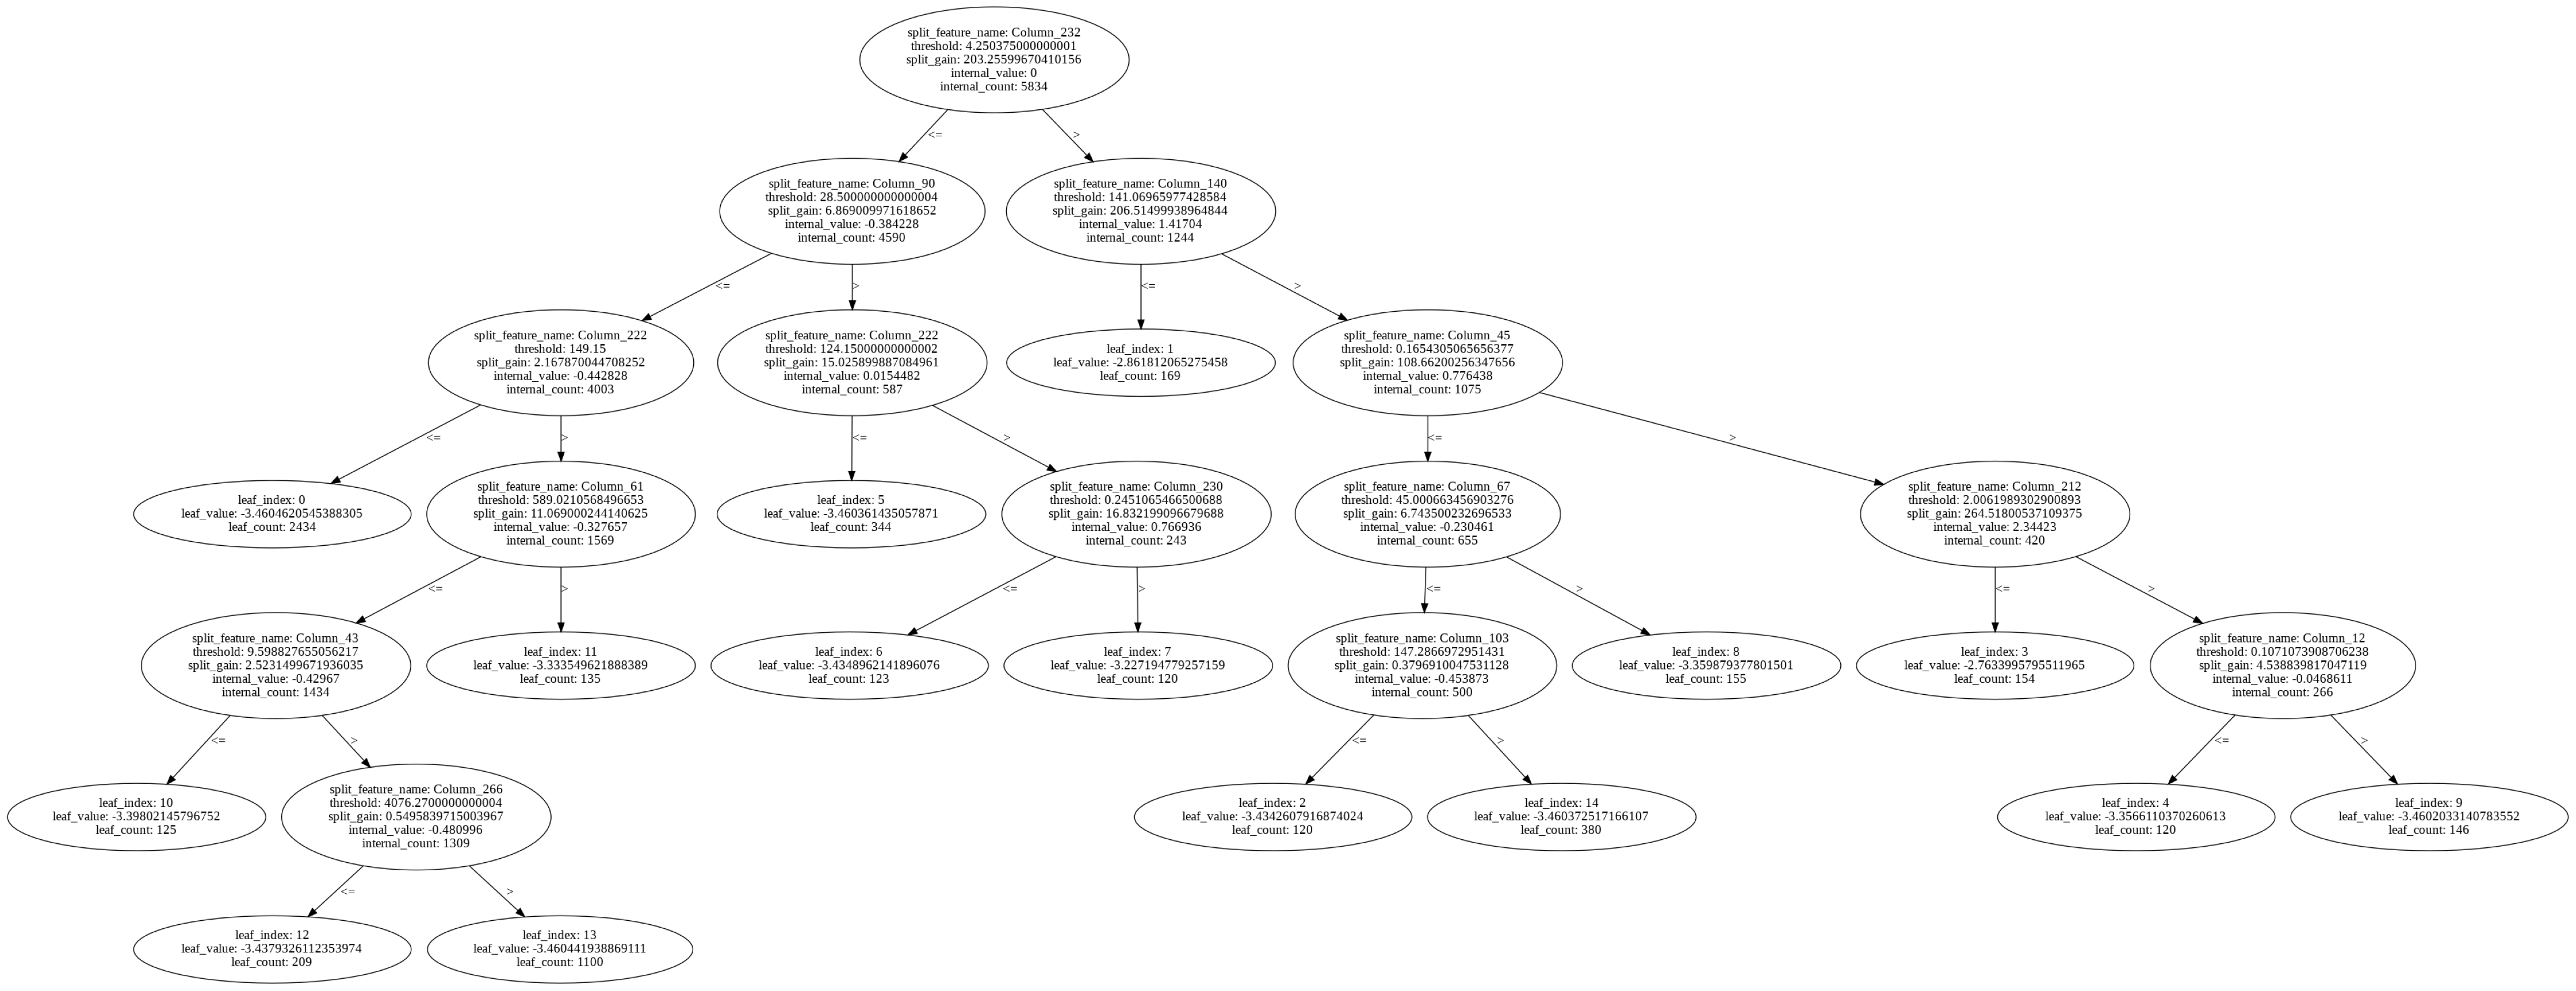

--------------- after plot begin ---------------





3it [03:28, 69.71s/it]

--------------- begin ---------------
Training until validation scores don't improve for 80 rounds.
[30]	training's multi_logloss: 0.762686	valid_1's multi_logloss: 1.12861
[60]	training's multi_logloss: 0.328345	valid_1's multi_logloss: 0.885748
[90]	training's multi_logloss: 0.143103	valid_1's multi_logloss: 0.811976
[120]	training's multi_logloss: 0.0604102	valid_1's multi_logloss: 0.782088
[150]	training's multi_logloss: 0.0257385	valid_1's multi_logloss: 0.775627
[180]	training's multi_logloss: 0.0116824	valid_1's multi_logloss: 0.781183
[210]	training's multi_logloss: 0.00633246	valid_1's multi_logloss: 0.791195
[240]	training's multi_logloss: 0.00485782	valid_1's multi_logloss: 0.795253
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0189812	valid_1's multi_logloss: 0.775303


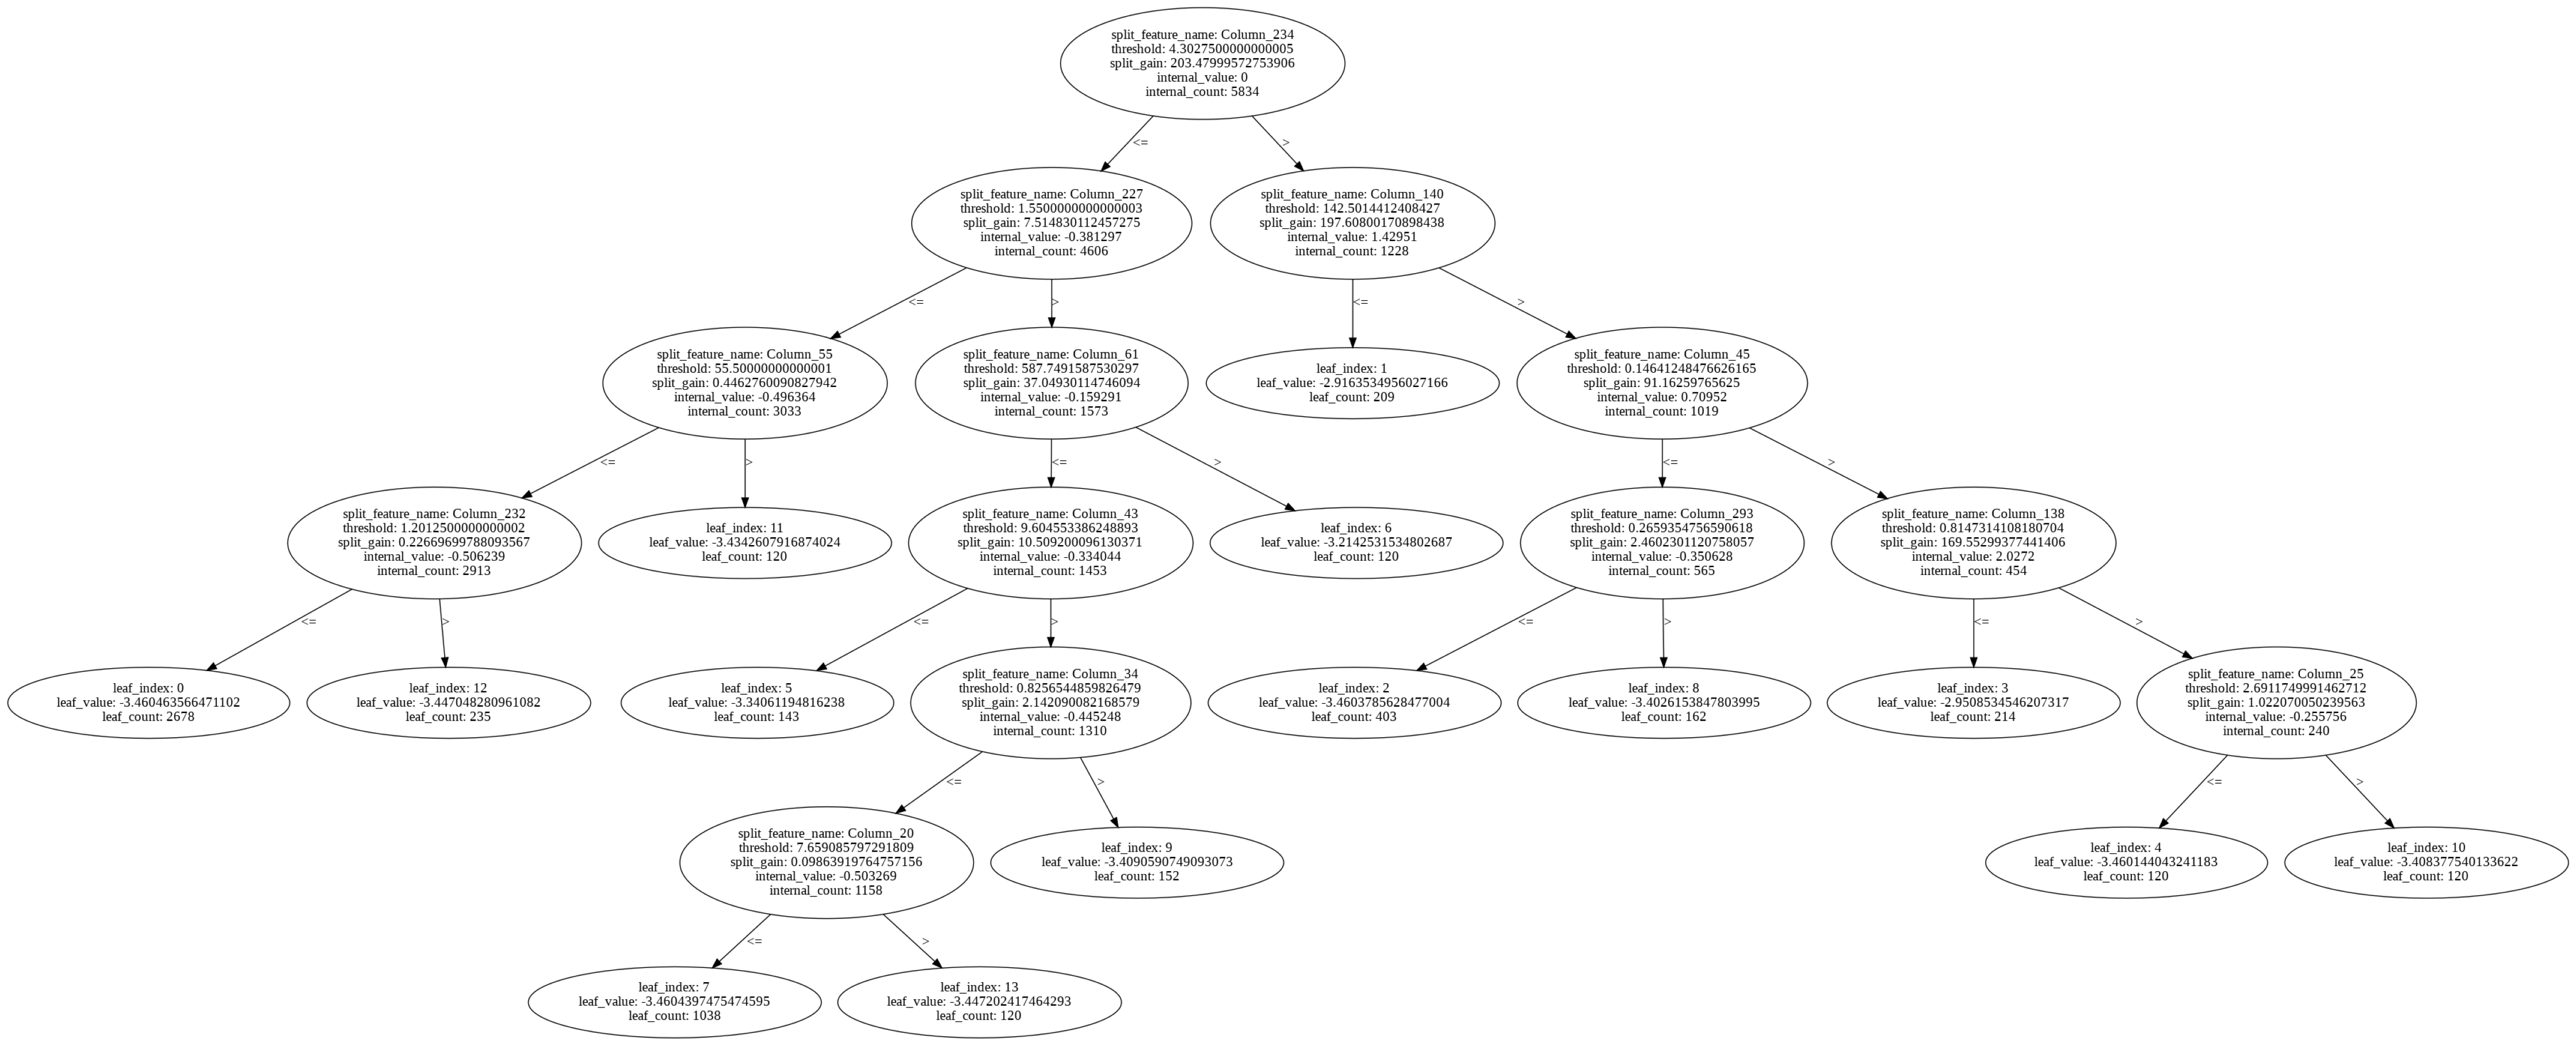

--------------- after plot begin ---------------





4it [04:39, 70.25s/it]

--------------- begin ---------------
Training until validation scores don't improve for 80 rounds.
[30]	training's multi_logloss: 0.763822	valid_1's multi_logloss: 1.13507
[60]	training's multi_logloss: 0.327044	valid_1's multi_logloss: 0.897715
[90]	training's multi_logloss: 0.140183	valid_1's multi_logloss: 0.821211
[120]	training's multi_logloss: 0.0588682	valid_1's multi_logloss: 0.788887
[150]	training's multi_logloss: 0.0247563	valid_1's multi_logloss: 0.785698
[180]	training's multi_logloss: 0.0110799	valid_1's multi_logloss: 0.791611
[210]	training's multi_logloss: 0.00606767	valid_1's multi_logloss: 0.805462
Early stopping, best iteration is:
[153]	training's multi_logloss: 0.0227647	valid_1's multi_logloss: 0.785211


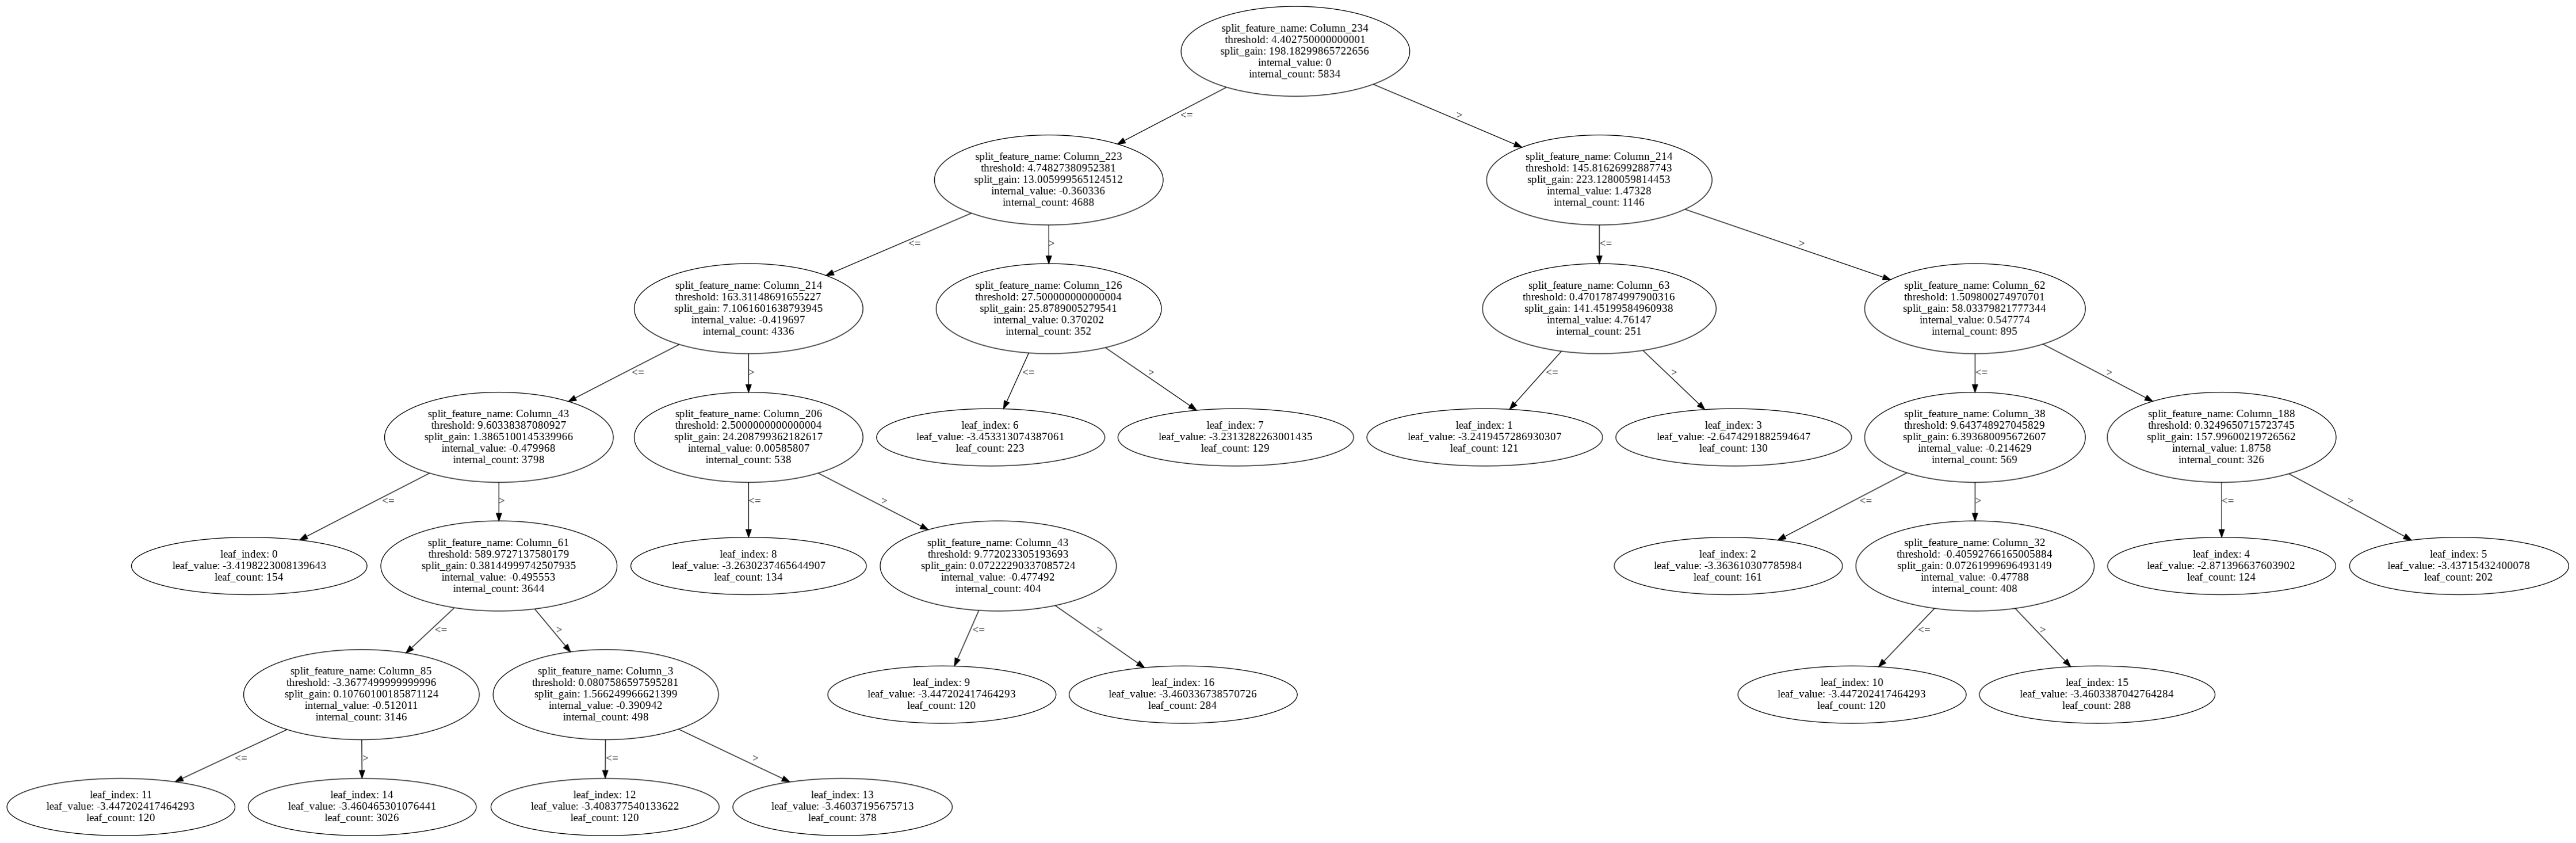

--------------- after plot begin ---------------





5it [05:55, 71.19s/it]


In [ ]:
for train_index, val_index in tqdm(kfold.split(X, y)):

    print('--------------- begin ---------------')
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    
    watchlist = [lgb_train, lgb_val]
    model = lgb.train(params,
                      train_set = lgb_train, 
                      num_boost_round = 5000,
                      valid_sets = watchlist,
                      verbose_eval = 30,
                      early_stopping_rounds = 80)
    
    lgb.plot_tree(model,figsize=(80,80),show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
    import matplotlib.pyplot as plt
    plt.show()
    print('--------------- after plot begin ---------------')

    X_val_predict = model.predict(X_val)
    X_test_predict = model.predict(X_test)
    
    df_train_stacking.loc[val_index,:] = X_val_predict
    df_test_stacking[:] += X_test_predict / folds

# 查看结果

In [ ]:
df_test_stacking.head()

0         1         2   ...        16        17        18
0  0.000350  0.001200  0.000140  ...  0.000181  0.000476  0.023689
1  0.027308  0.042475  0.000141  ...  0.000069  0.000232  0.001648
2  0.002719  0.322488  0.002348  ...  0.000580  0.000454  0.001796
3  0.068867  0.522497  0.000240  ...  0.000191  0.002615  0.000548
4  0.001185  0.000891  0.000275  ...  0.002572  0.007314  0.600875

[5 rows x 19 columns]

# 模型得分和保存

In [ ]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [ ]:
labels = np.argmax(df_test_stacking.values, axis=1)
pred_y = np.argmax(df_train_stacking.values, axis=1)


acc_scores = round(accuracy_score(y, pred_y), 5)
acc_combo_scores = round(sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y, pred_y)) / len(list(y)),5)

print('--------')
print(' acc : ', acc_scores, 'acc_combo : ', acc_combo_scores)

df_out = df_train_test_features[df_train_test_features['flag']=='test'][['fragment_id']]
df_out['behavior_id'] = labels
df_out.to_csv('./submit_lgb_%.5f_%.5f.csv' % (acc_scores, acc_combo_scores), index=False)

--------
 acc :  0.73491 acc_combo :  0.7755
